In [1]:
# Parameters
animal = "58-21"
col_names = ["time", "g1", "g2", "g3", "g4", "du1", "du2"]
chan_to_keep = ["time", "g1", "g2", "g3", "g4"]
new_sample_freq = 200
original_sample_freq = 2000
filter_type = "bandpass"
lo_cutoff = 0.05
hi_cutoff = 0.7
use_dropped_packet_removal = True
use_artifact_removal = True
pre_post_pts = 10
fill_frontend = True


# Load modules

In [2]:
# load modules
from rich import print
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from directory_structure import Tree
import sys, os
import os.path as path
import glob
import re
import pickle

modules = path.abspath(path.join(os.getcwd(), "helpers"))
print(modules)
sys.path.insert(0, modules)

from import_files import *
from preprocessing import *
from plotting import *

%matplotlib inline

/home/github_repos/PITT_NN_paper/1_preprocessing/helpers

# Load data, rename columns, save/load to pickles to increase speed (and remove channels)

In [3]:
# get list of files and pickles
####################################

file_lst = glob.glob("Data/" + animal + "/*.txt")
print(file_lst)

pickle_lst = glob.glob("pickles/" + animal + "*.pckl")
print(pickle_lst)

# make df names
####################################

df_name_lst = []
for x in file_lst:
    if 'eed' in x:
        df_name_lst.append('df_feed')
    if 'ase' in x:
        df_name_lst.append('df_base')

# load pickles or make pickles
####################################

if len(file_lst) == len(pickle_lst):
    print("import pickles")
    for x, y in zip(pickle_lst, df_name_lst):
        print(y)
        df_x = Import.open_pickle(x)
        exec(y + " = df_x")
        print()
else:
    print("import CSVs and make pickles")
    for x, y in zip(file_lst, df_name_lst):
        print(y)
        df_x = Import.csv_import_to_pandas(file_path=x, df_name=y, print_df=False)
        df_x.columns = col_names
        # drop channel
        df_x = df_x[chan_to_keep]
        print(df_x)
        # store pickle
        # create directory if it does not exist
        file_path = 'pickles/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        Import.store_pickle(obj=df_x, file_path='pickles/' + animal + '_' + y +'.pckl')
        exec(y + " = df_x")
        print()

['Data/58-21/58-21_Baseline_6-21-21.txt', 'Data/58-21/58-21_Feeding_6-23-21.txt']

['pickles/58-21_df_base.pckl', 'pickles/58-21_df_feed.pckl']

import pickles

df_base

time            g1            g2            g3            g4
0           0.0000  46693.656250  24877.603516  43749.855469   8656.220703
1           0.0005  46690.582031  24879.085938  43766.300781   8647.064453
2           0.0010  46690.953125  24878.953125  43771.875000   8645.355469
3           0.0015  46696.460938  24876.044922  43761.906250   8651.049805
4           0.0020  46700.402344  24872.671875  43745.613281   8658.023438
...            ...           ...           ...           ...           ...
7200027  3600.0135  52844.945313  32686.191406  42263.363281  11699.115234
7200028  3600.0140  52856.953125  32675.203125  42270.277344  11712.683594
7200029  3600.0145  52845.746094  32688.585938  42274.707031  11700.809570
7200030  3600.0150  52822.820313  32712.519531  42277.449219  11682.077148
7200031  3600.0155  52811.320313  32728.242188  42277.125000  11684.619141

[7200032 rows x 5 columns]

df_feed

time            g1           g2            g3            g4
0           0.0000  36514.742188  6507.922852  24579.074219 -11899.834961
1           0.0005  36518.519531  6510.704102  24588.607422 -11888.161133
2           0.0010  36520.289063  6509.393066  24595.947266 -11879.237305
3           0.0015  36516.457031  6498.666016  24582.910156 -11877.301758
4           0.0020  36505.523438  6483.101074  24565.710938 -11875.730469
...            ...           ...          ...           ...           ...
7234572  3617.2860  42656.667969 -1756.363037   4673.409180 -29792.726563
7234573  3617.2865  42652.250000 -1755.180542   4681.628906 -29793.669922
7234574  3617.2870  42650.328125 -1756.162964   4687.505859 -29791.904297
7234575  3617.2875  42651.359375 -1756.008057   4687.853516 -29788.419922
7234576  3617.2880  42651.398438 -1756.553223   4683.228516 -29783.804688

[7234577 rows x 5 columns]

## Determine percentage missing values

In [4]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[4.7549, 4.7549, 4.7549, 4.7549]

#####################

# Downsample after applying anti-aliasing filter

In [5]:
factor = int(original_sample_freq / new_sample_freq)
print(factor)

for x in df_name_lst:

    df1 = locals()[x]

    # get df with time values
    df_x = df1.iloc[::factor, :].time
    df_x.reset_index(drop=True, inplace=True)
    df_x = pd.DataFrame(df_x)

    for y in chan_to_keep[1:]:    
        arr = Preprocessing.downsample_with_anti_aliasing(arr=df1[y], factor=factor, ftype='iir')
        df_x[y] = arr.tolist()

    exec(x + " = df_x")
    print(df_x)

10

Original length = 7200032
New length = 720004
Original length = 7200032


New length = 720004
Original length = 7200032
New length = 720004
Original length = 7200032


New length = 720004


time            g1            g2            g3            g4
0          0.000  46158.785099  24592.810656  43242.385701   8556.977152
1          0.005  46167.308488  24585.105692  43232.397160   8556.655951
2          0.010  46168.251583  24578.829965  43222.930420   8559.776013
3          0.015  46175.783436  24575.262859  43426.134241   8560.078543
4          0.020  46186.548716  24569.807549  43883.978313   8561.908452
...          ...           ...           ...           ...           ...
719999  3599.995  52236.921278  32251.863098  41808.071320  11565.964681
720000  3600.000  52223.655649  32361.632247  41789.240508  11563.519788
720001  3600.005  52229.006148  32378.167764  41766.064730  11577.719129
720002  3600.010  52219.605991  32364.257941  41772.290773  11575.714773
720003  3600.015  52204.899588  32357.966635  41788.677092  11554.741915

[720004 rows x 5 columns]

Original length = 7234577
New length = 723458


Original length = 7234577


New length = 723458
Original length = 7234577


New length = 723458
Original length = 7234577


New length = 723458


time            g1           g2            g3            g4
0          0.000  36098.581874  6433.437194  24303.423698 -11763.676880
1          0.005  36053.191547  6400.291821  24175.604723 -11754.558975
2          0.010  36056.781273  6450.476879  23859.625362 -11781.937725
3          0.015  36106.743637  6440.466228  23690.107401 -11821.140871
4          0.020  36088.279363  6422.659517  23490.783927 -11829.380921
...          ...           ...          ...           ...           ...
723453  3617.265  42217.442701 -1757.930461   4588.243498 -29457.027073
723454  3617.270  42227.726254 -1744.193374   4605.556339 -29454.563983
723455  3617.275  42195.464564 -1742.614214   4595.392970 -29461.755807
723456  3617.280  42165.021296 -1744.106894   4589.362927 -29464.150274
723457  3617.285  42165.211343 -1738.250495   4616.534103 -29450.003937

[723458 rows x 5 columns]

## Determine percentage missing values

In [6]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Remove dropped packets (errors in the hardware recording)

In [7]:
if use_dropped_packet_removal:
    
    df_packet_drop = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:

            df_x[y], removed_pct = Preprocessing.remove_dropped_packets_zerofill(arr=df_x[y], thres=100000)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
            
        exec(x + ' = df_x')
 
    df_packet_drop['cond'] = cond_lst
    df_packet_drop['chan'] = chan_lst
    df_packet_drop['removed_pct'] = removed_pct_lst
    
    print(df_packet_drop)

cond chan  removed_pct
0  df_base   g1         0.45
1  df_base   g2         0.45
2  df_base   g3         0.45
3  df_base   g4         0.45
4  df_feed   g1        18.27
5  df_feed   g2        18.35
6  df_feed   g3        17.85
7  df_feed   g4        18.16

## Determine percentage missing values

In [8]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.4475, 0.44694, 0.44764, 0.44708]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[18.27432, 18.35407, 17.849, 18.16498]

#####################

# Plot raw signals

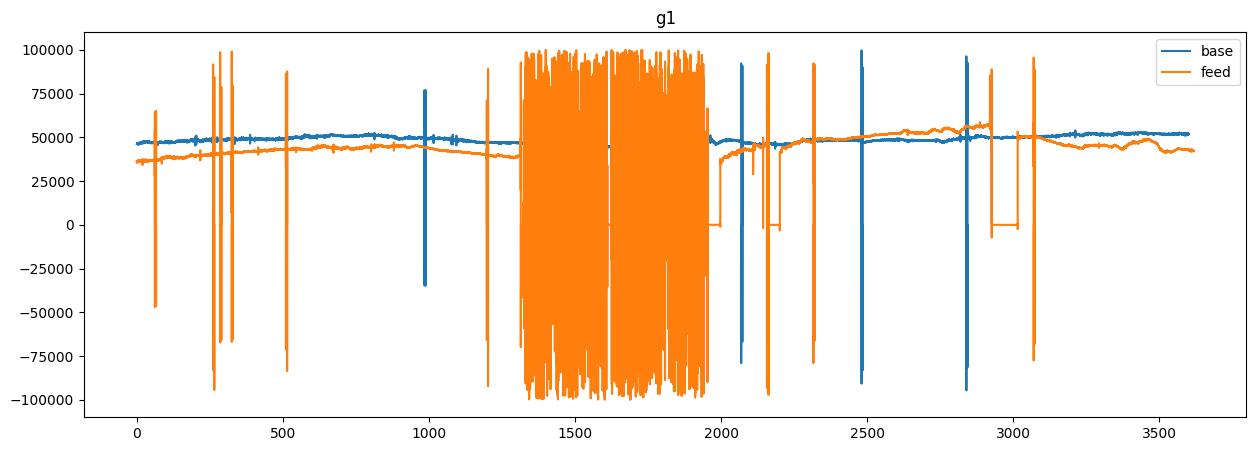

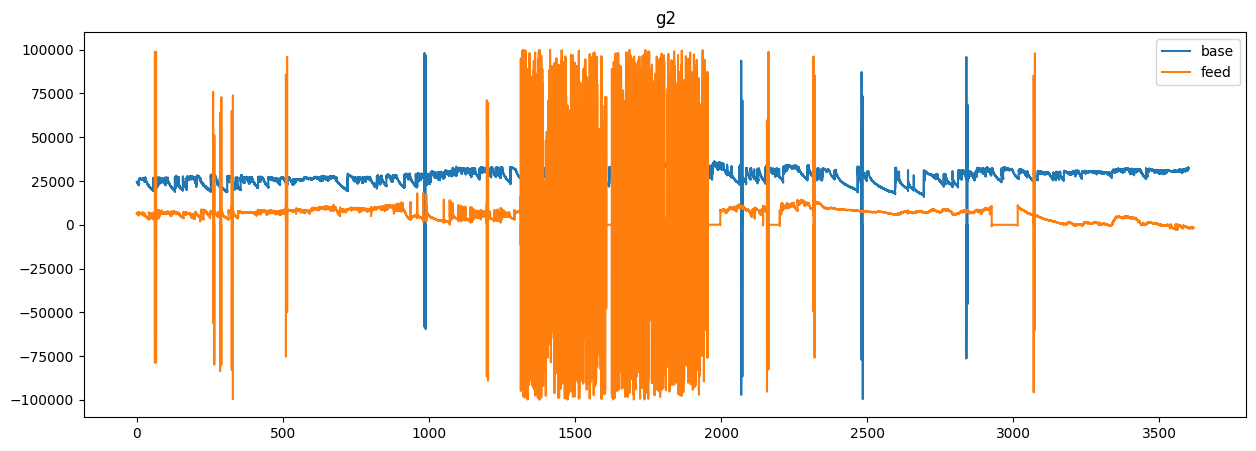

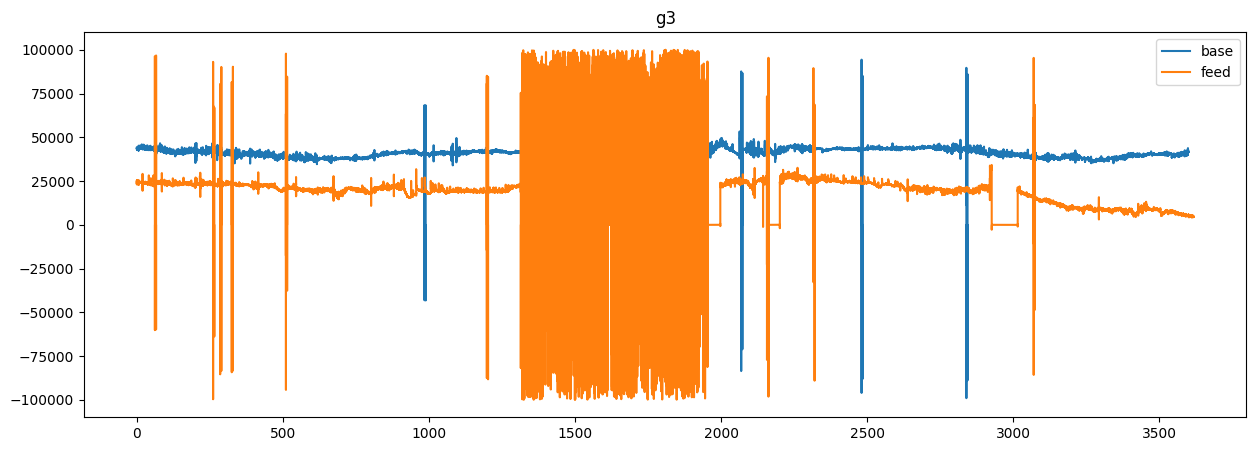

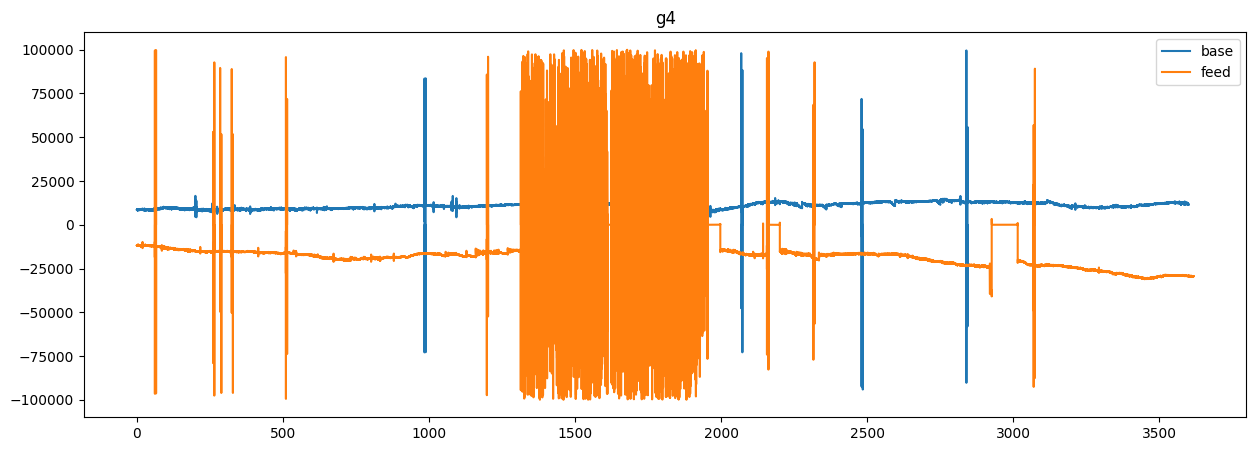

In [9]:
for x in chan_to_keep[1:]:
    plt.figure(figsize=(15,5))
    plt.title(x)
    plt.plot(df_base['time'], df_base[x], label='base')
    plt.plot(df_feed['time'], df_feed[x], label='feed')
    plt.legend(loc='upper right')

# Apply filters

## If band pass

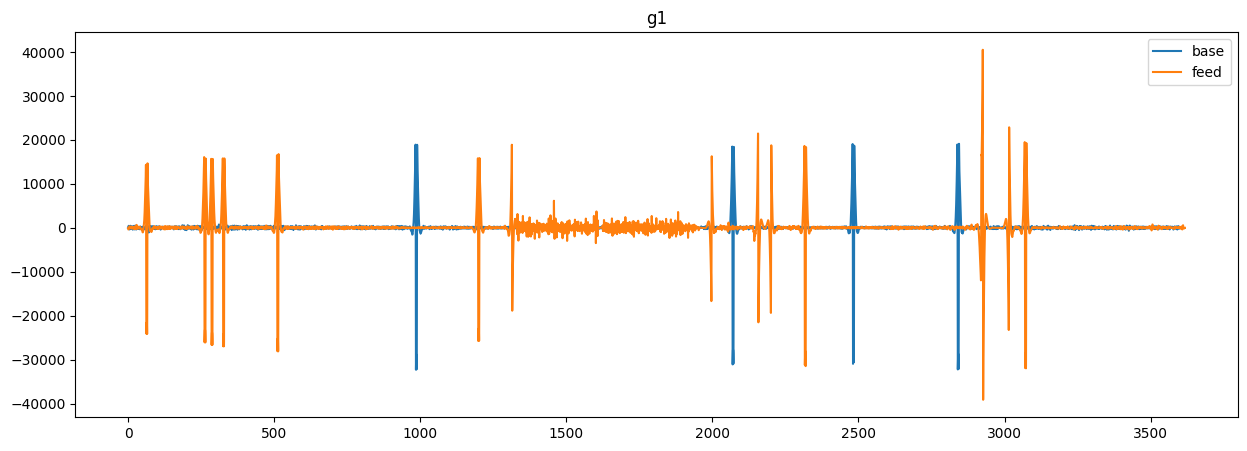

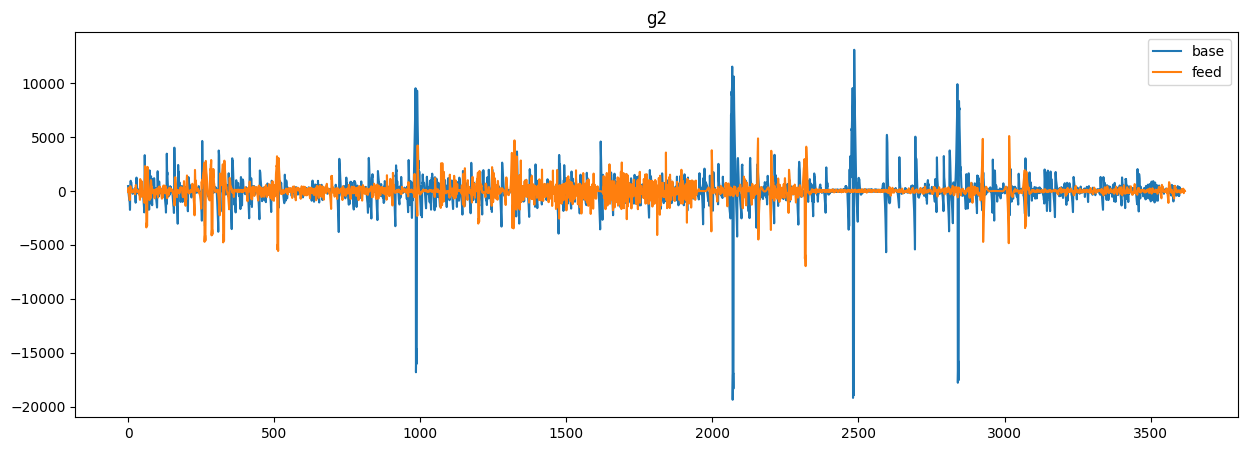

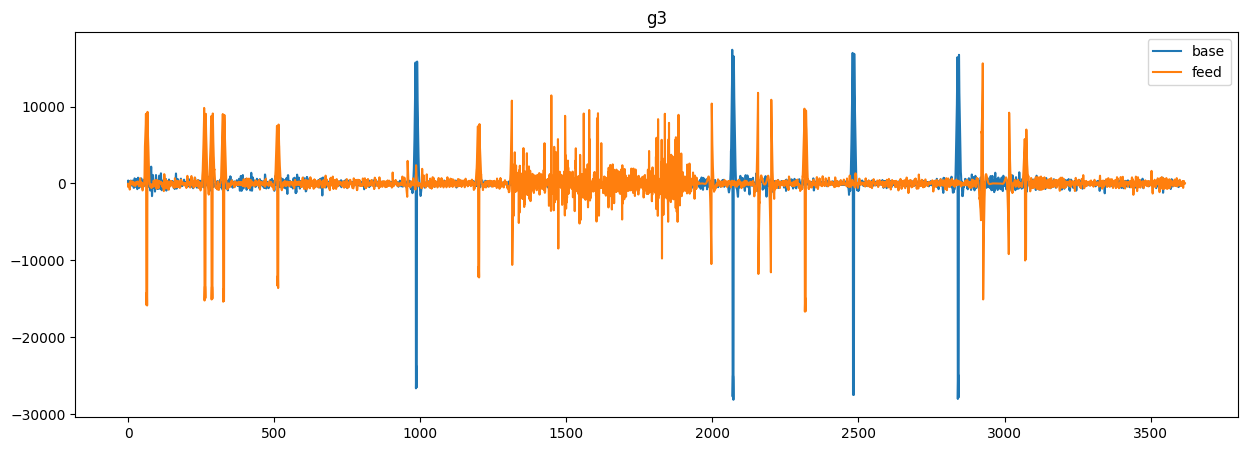

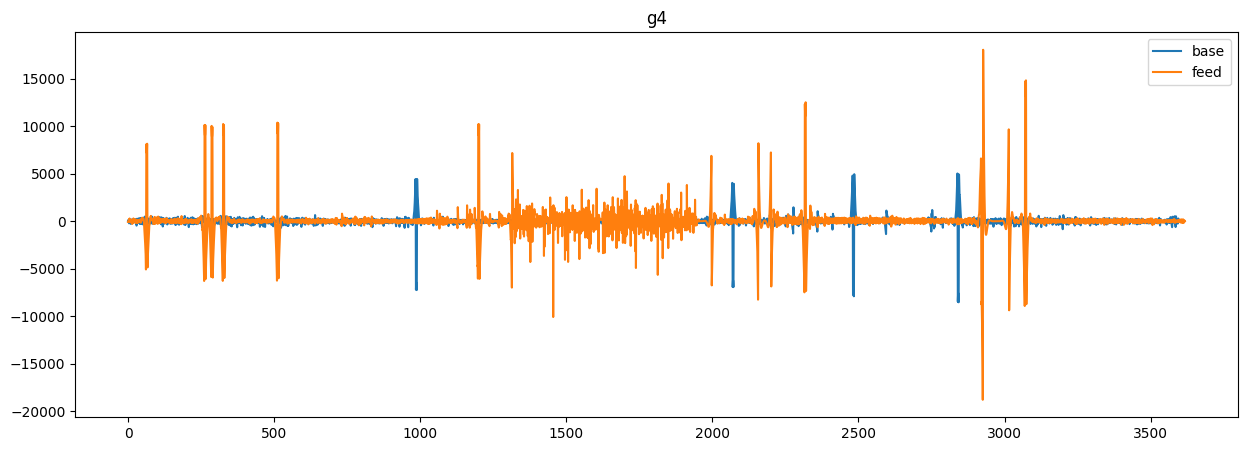

In [10]:
if filter_type == 'bandpass':
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.bandpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           lowcut=lo_cutoff, highcut=hi_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If high pass

In [11]:
if (filter_type == 'butter_high_low') or (filter_type == 'butter_high_savgol_low') or (filter_type == 'butter_high_only'):
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.highpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, cutoff_freq=lo_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If low pass

In [12]:
if filter_type == 'butter_high_low':
        
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.lowpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           cutoff_freq=hi_cutoff)
        exec(x + ' = df_x')
        
    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

if filter_type == 'butter_high_savgol_low':
            
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            arr = Preprocessing.savitzky_golay_filter(arr=df_x[y].values, win_len=sg_len, order=sg_order)
            df_x[y] = pd.Series(arr)
        exec(x + ' = df_x')

    for x in col_names[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [13]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Artifact removal > 2 mV

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 1.97 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 6.14 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 1.92 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 1.24 %


time         g1          g2          g3         g4
0          0.000 -82.358764  457.692709  174.543251  47.257094
1          0.005 -81.393042  457.050630  179.955087  47.858084
2          0.010 -80.421759  456.400137  185.331009  48.463041
3          0.015 -79.445165  455.741347  190.667723  49.071848
4          0.020 -78.463509  455.074375  195.961969  49.684384
...          ...        ...         ...         ...        ...
719999  3599.995  -1.117409   -0.069150    0.175512  -0.345653
720000  3600.000  -0.956122   -0.063346    0.150093  -0.296347
720001  3600.005  -0.810504   -0.057259    0.127201  -0.251728
720002  3600.010  -0.679920   -0.051027    0.106715  -0.211623
720003  3600.015  -0.563696   -0.044780    0.088511  -0.175844

[720004 rows x 5 columns]

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 6.46 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 2.84 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 7.32 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 5.37 %


time          g1         g2         g3         g4
0          0.000 -103.275194 -44.268938 -48.335235 -93.587483
1          0.005 -105.183114 -46.252770 -56.560909 -93.887217
2          0.010 -107.086653 -48.229127 -64.772111 -94.181336
3          0.015 -108.985129 -50.197190 -72.964466 -94.469599
4          0.020 -110.877865 -52.156133 -81.133666 -94.751770
...          ...         ...        ...        ...        ...
723453  3617.265    0.599632   0.377512  -0.352061   0.030989
723454  3617.270    0.520352   0.322029  -0.302166   0.024781
723455  3617.275    0.447304   0.272123  -0.257005   0.019531
723456  3617.280    0.380459   0.227541  -0.216374   0.015141
723457  3617.285    0.319762   0.188022  -0.180071   0.011519

[723458 rows x 5 columns]

cond chan  removed_pct
0  df_base   g1         1.97
1  df_base   g2         6.14
2  df_base   g3         1.92
3  df_base   g4         1.24
4  df_feed   g1         6.46
5  df_feed   g2         2.84
6  df_feed   g3         7.32
7  df_feed   g4         5.37

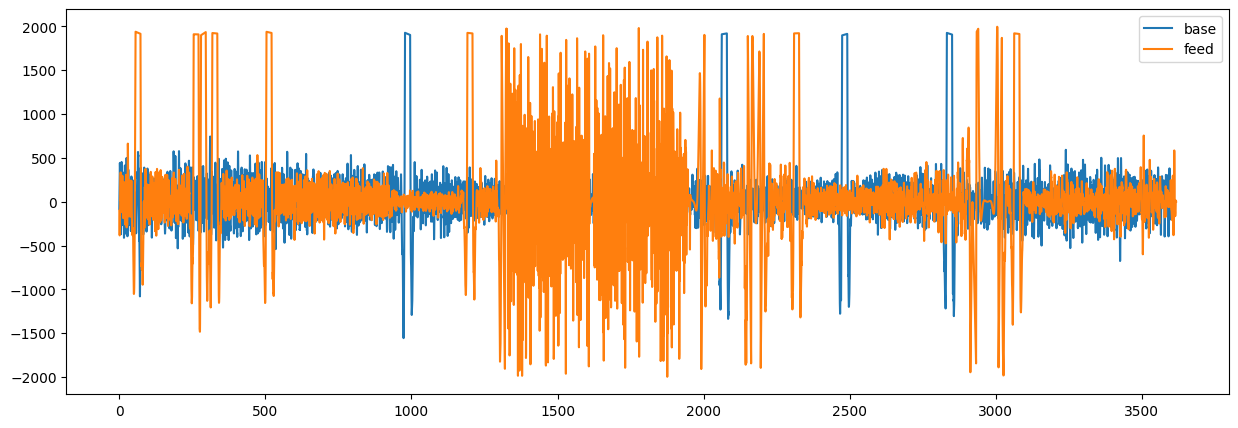

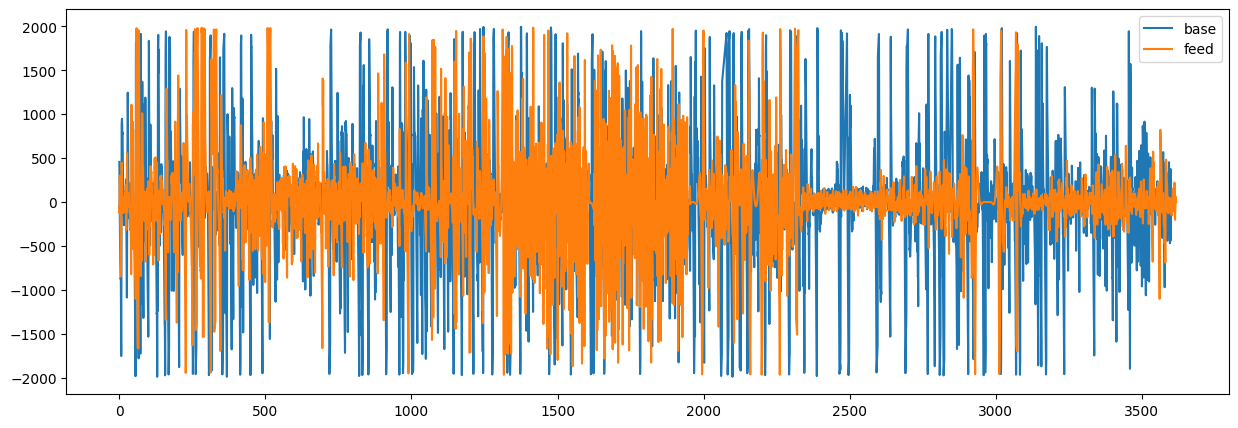

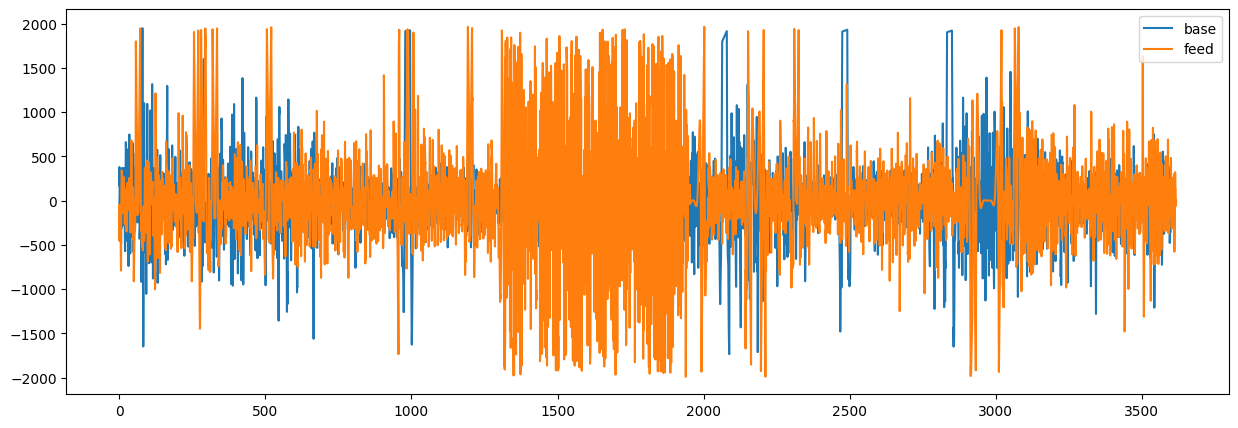

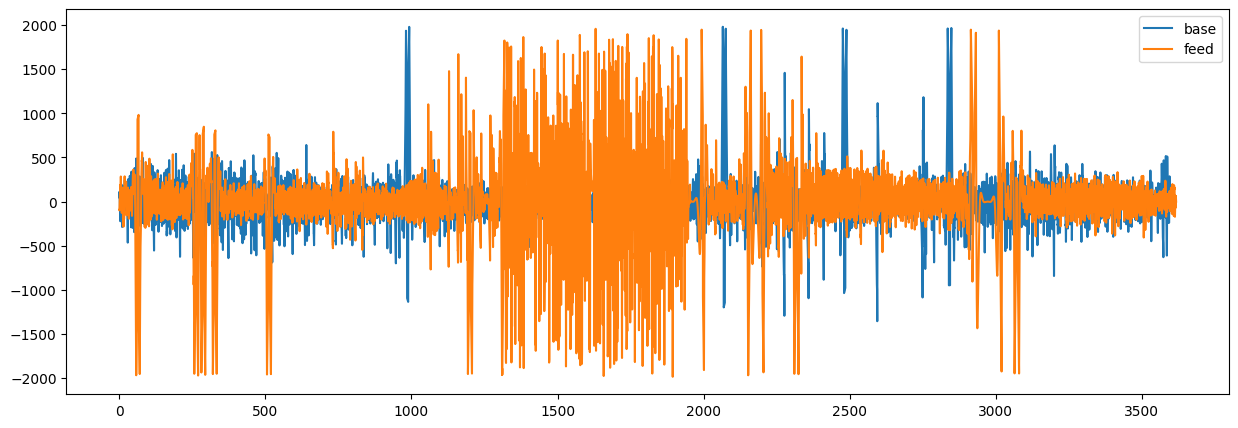

In [14]:
if use_artifact_removal:
    
    df_artifact_remove = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:
            
            # apply filter
            df_x[y], removed_pct = Preprocessing.artifacts_removal(arr=df_x[y], thres=2000, 
                                                                   pts_pre=pre_post_pts, 
                                                                   pts_post=pre_post_pts, 
                                                                   interpolate=True,
                                                                   fill_frontend=fill_frontend)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
        print(df_x)   
        exec(x + ' = df_x')
 
    df_artifact_remove['cond'] = cond_lst
    df_artifact_remove['chan'] = chan_lst
    df_artifact_remove['removed_pct'] = removed_pct_lst
    
    print(df_artifact_remove)

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [15]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Plots: power spectral density (from 3 to 15 cpm)

df_base

Total power = 76204523.46144095 Dom freq = 0.1738879228448731

Bradygastric power = 40821700.19904609 Dom freq = 0.0699996111132716

normygastric power = 31388696.855764642 Dom freq = 0.1738879228448731

tachygastric power = 3994126.406630218 Dom freq = 0.19055449691946158

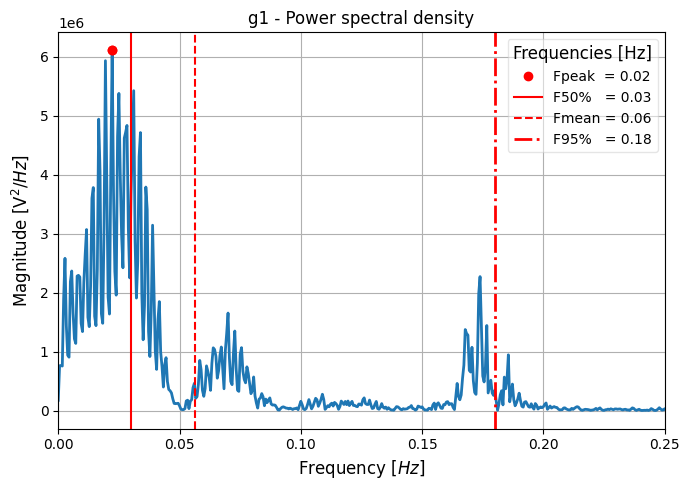

Total power = 829364393.1384268 Dom freq = 0.06611074382920096

Bradygastric power = 623055129.4345065 Dom freq = 0.06611074382920096

normygastric power = 151191078.27375224 Dom freq = 0.1672212932150377

tachygastric power = 55118185.43016796 Dom freq = 0.20999883333981478

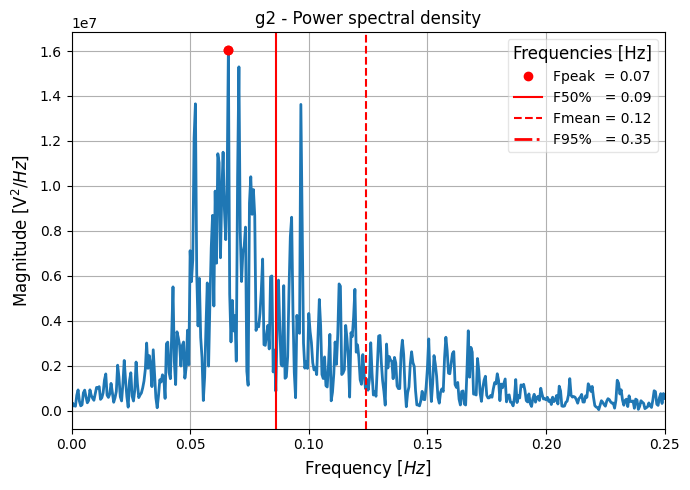

Total power = 143021508.97821328 Dom freq = 0.0688885061749657

Bradygastric power = 76970048.2763573 Dom freq = 0.0688885061749657

normygastric power = 54134651.13122265 Dom freq = 0.1661101882767318

tachygastric power = 11916809.57063335 Dom freq = 0.19444336420353223

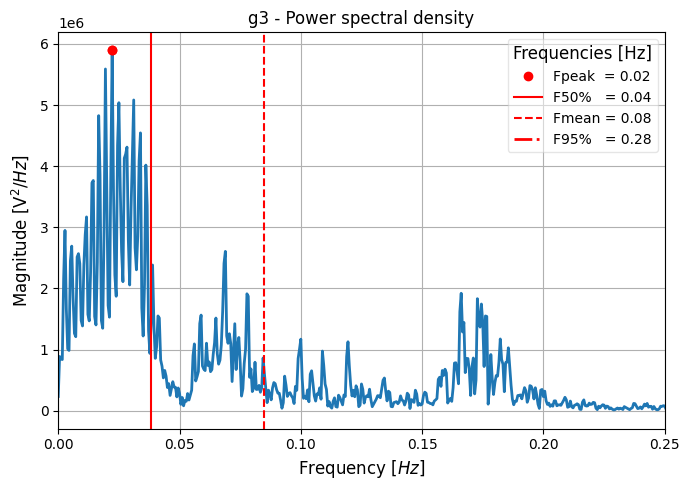

Total power = 117273420.64619926 Dom freq = 0.07277737345903634

Bradygastric power = 83437852.25078723 Dom freq = 0.07277737345903634

normygastric power = 28347591.17352352 Dom freq = 0.17333237037572014

tachygastric power = 5487977.2218885 Dom freq = 0.19777667901844992

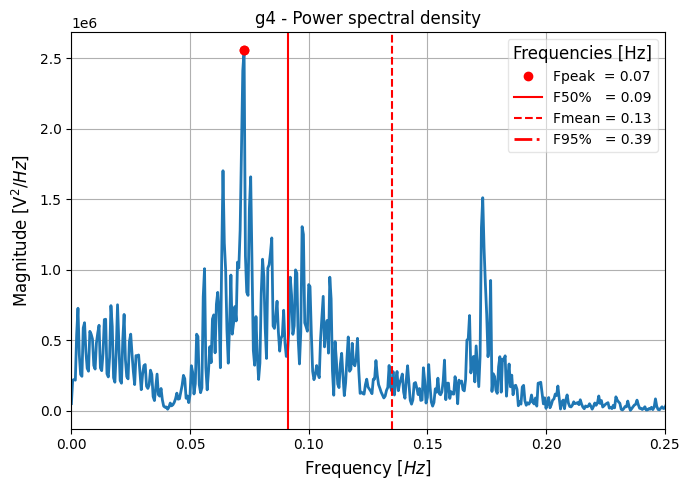

df_feed

Total power = 199600446.18500572 Dom freq = 0.058054510420784626

Bradygastric power = 131284011.04946628 Dom freq = 0.058054510420784626

normygastric power = 41998983.535392396 Dom freq = 0.17637513165933616

tachygastric power = 26317451.600147046 Dom freq = 0.19240923453745762

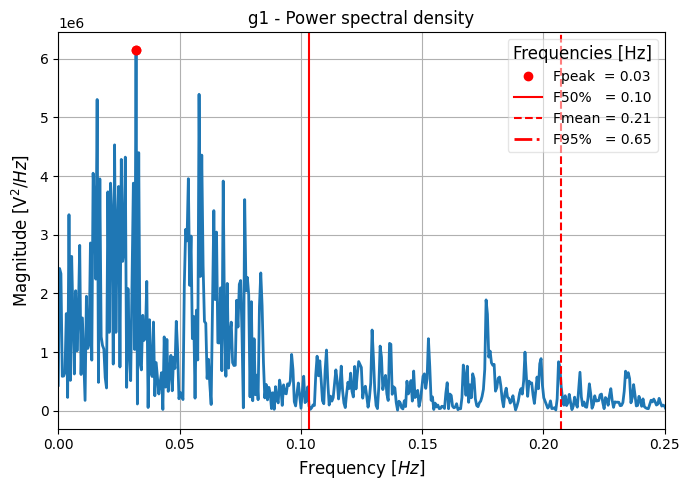

Total power = 311560616.51756644 Dom freq = 0.07685311379513393

Bradygastric power = 178666821.7028598 Dom freq = 0.07685311379513393

normygastric power = 73926748.2841661 Dom freq = 0.12827282302497175

tachygastric power = 58967046.53054055 Dom freq = 0.1913034343389665

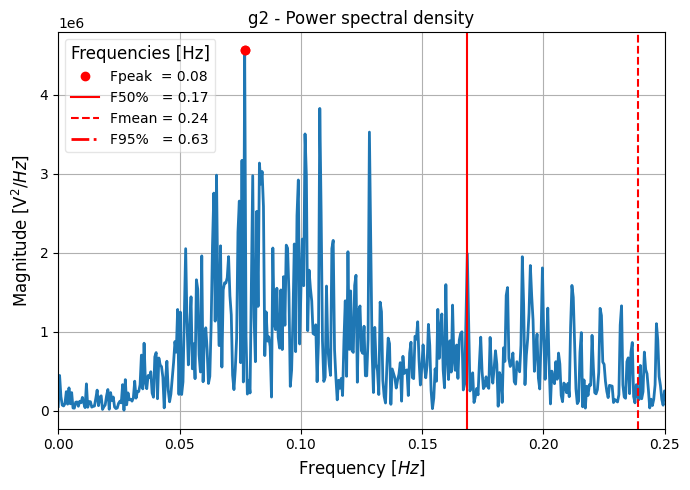

Total power = 405422075.40478575 Dom freq = 0.058054510420784626

Bradygastric power = 217578170.5919181 Dom freq = 0.058054510420784626

normygastric power = 97341055.99624227 Dom freq = 0.14651852630007547

tachygastric power = 90502848.81662537 Dom freq = 0.2067846371178424

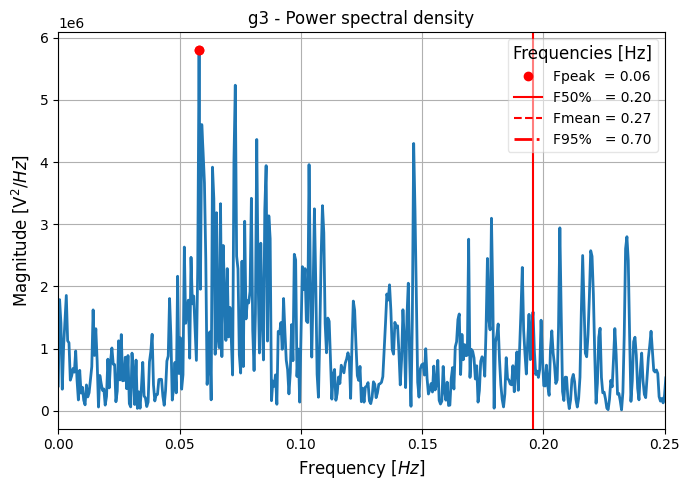

Total power = 232255310.26654473 Dom freq = 0.07685311379513393

Bradygastric power = 143998763.077963 Dom freq = 0.07685311379513393

normygastric power = 43902512.74519715 Dom freq = 0.13546052431516412

tachygastric power = 44354034.44338462 Dom freq = 0.1962795352321766

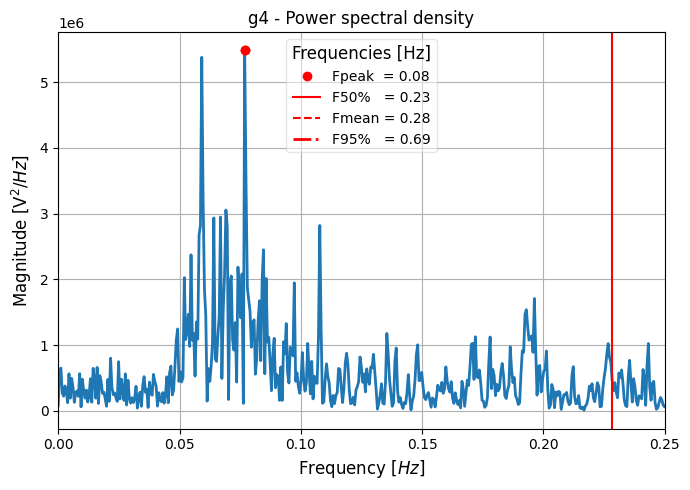

cond chan     tot_power    brad_power    norm_power    tach_power  \
0  df_base   g1  7.620452e+07  4.082170e+07  3.138870e+07  3.994126e+06   
0  df_base   g2  8.293644e+08  6.230551e+08  1.511911e+08  5.511819e+07   
0  df_base   g3  1.430215e+08  7.697005e+07  5.413465e+07  1.191681e+07   
0  df_base   g4  1.172734e+08  8.343785e+07  2.834759e+07  5.487977e+06   
0  df_feed   g1  1.996004e+08  1.312840e+08  4.199898e+07  2.631745e+07   
0  df_feed   g2  3.115606e+08  1.786668e+08  7.392675e+07  5.896705e+07   
0  df_feed   g3  4.054221e+08  2.175782e+08  9.734106e+07  9.050285e+07   
0  df_feed   g4  2.322553e+08  1.439988e+08  4.390251e+07  4.435403e+07   

   brad_domf  norm_domf  tach_domf  
0     0.0700     0.1739     0.1906  
0     0.0661     0.1672     0.2100  
0     0.0689     0.1661     0.1944  
0     0.0728     0.1733     0.1978  
0     0.0581     0.1764     0.1924  
0     0.0769     0.1283     0.1913  
0     0.0581     0.1465     0.2068  
0     0.0769     0.1355     0.1963

#########################################################

In [16]:
df_summary = pd.DataFrame()

for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        df_final = Plotting.psd(df_x[y], fs=new_sample_freq, xlim=[0,0.25], units='V', title=y, 
                                tot_pwr_lst=[0.05, 0.25], brad_pwr_lst=[0.05, 0.127], norm_pwr_lst=[0.127, 0.19], tach_pwr_lst=[0.19, 0.25])
        df_final['cond'] = x
        df_final['chan'] = y
        df_summary = pd.concat([df_summary, df_final])
    exec(x + '_summary = df_summary')

# change the order of columns and drop a column
df_summary = df_summary[['cond', 'chan', 'tot_power', 'brad_power', 'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf']]
    
print(df_summary)

print('#########################################################')
print()

# Plot spectrograms

df_base

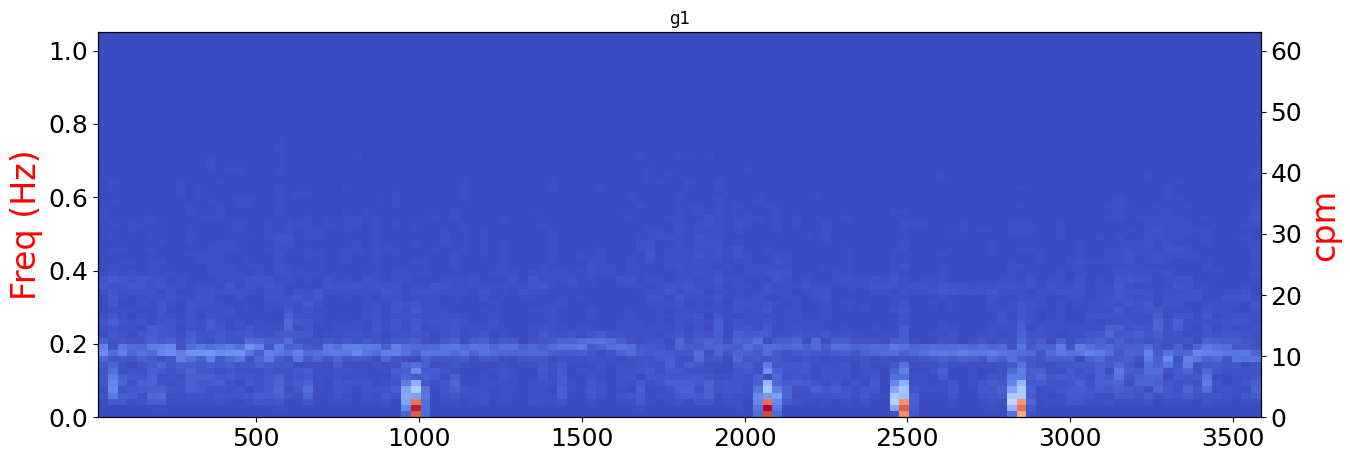

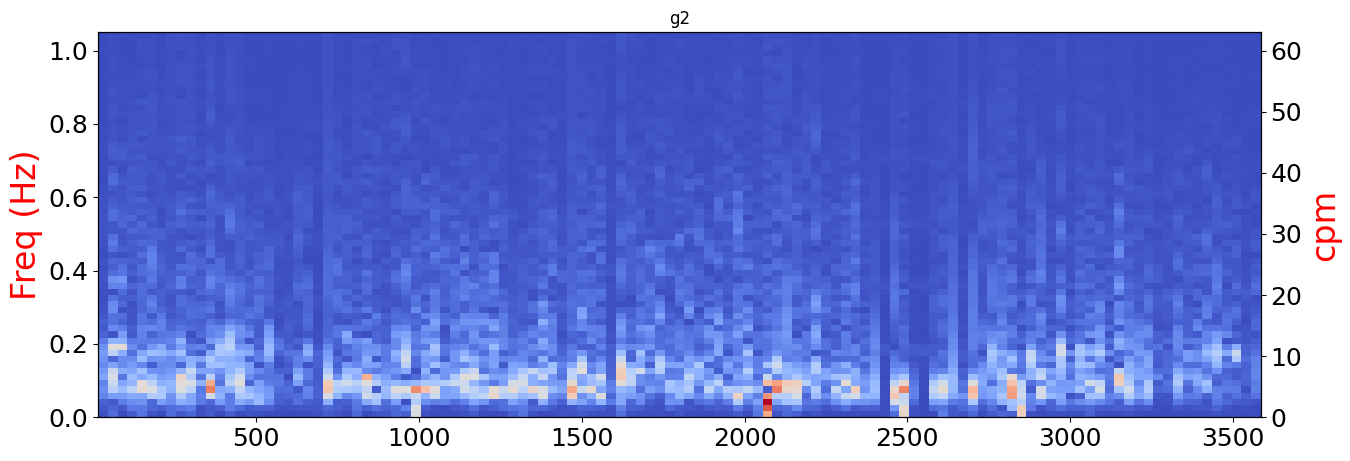

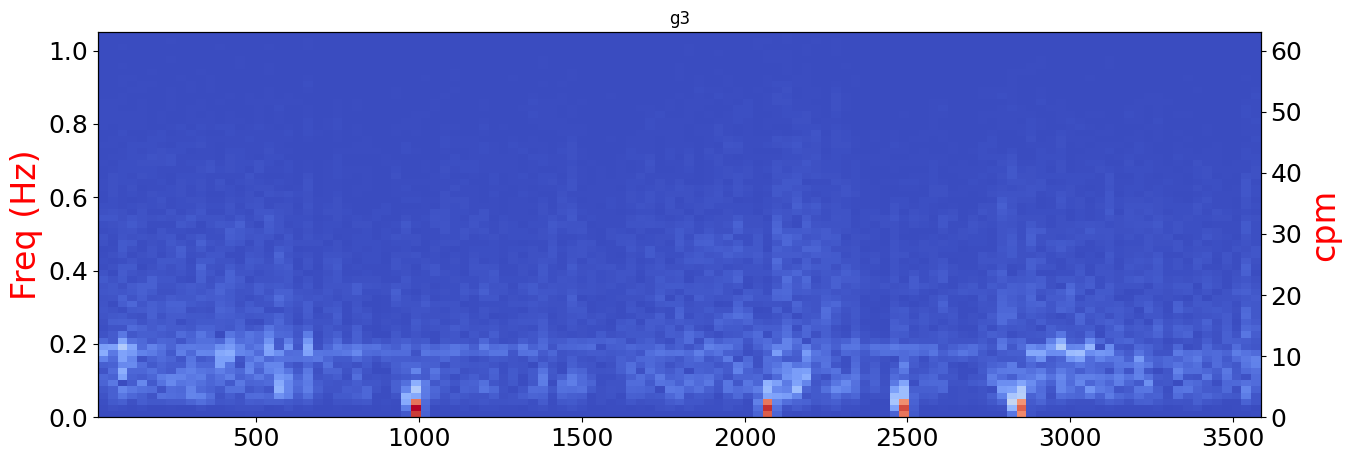

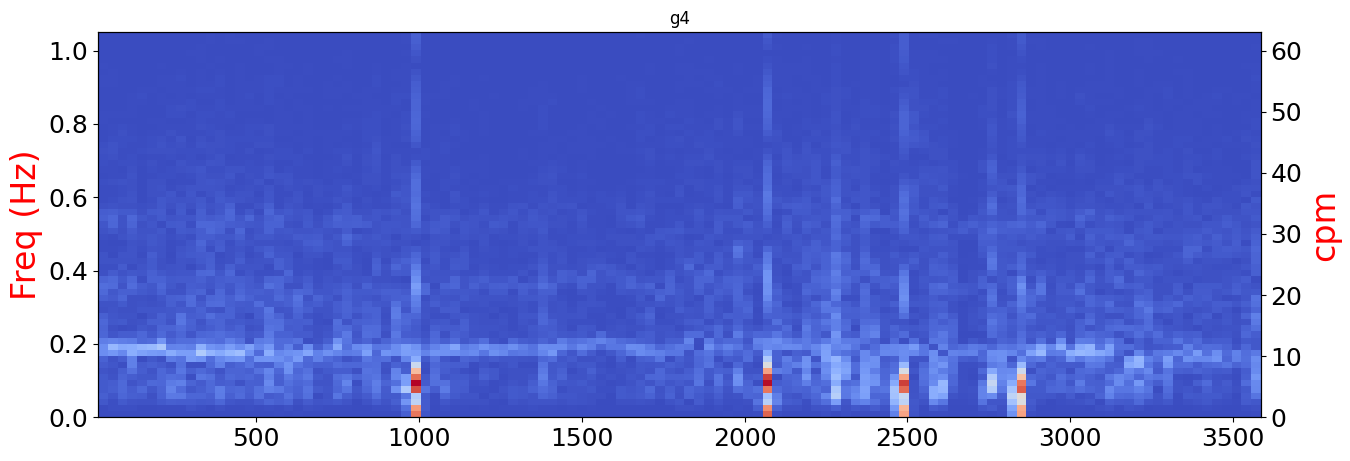

#########################################################

df_feed

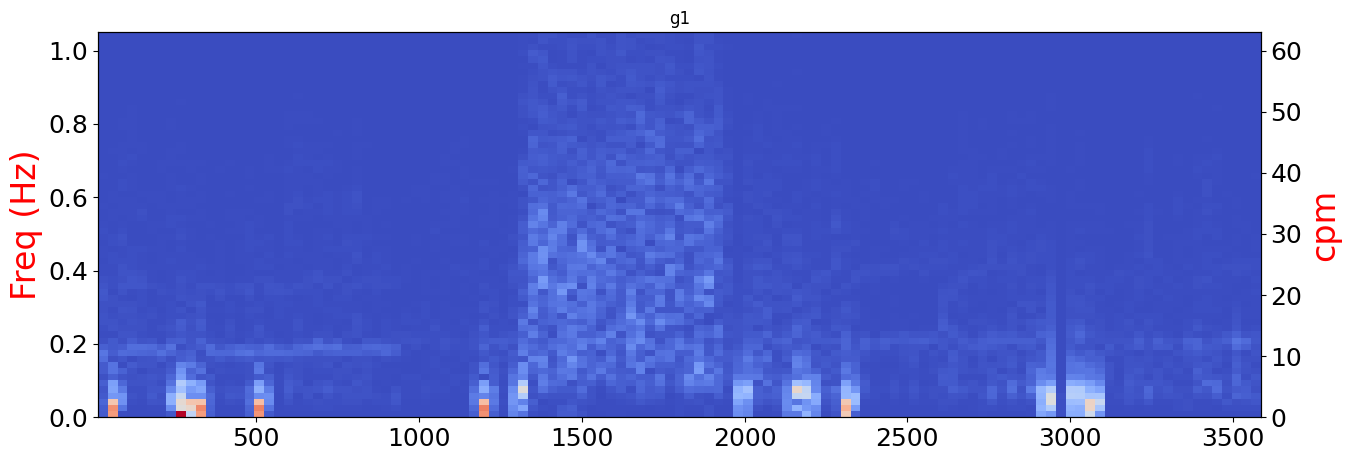

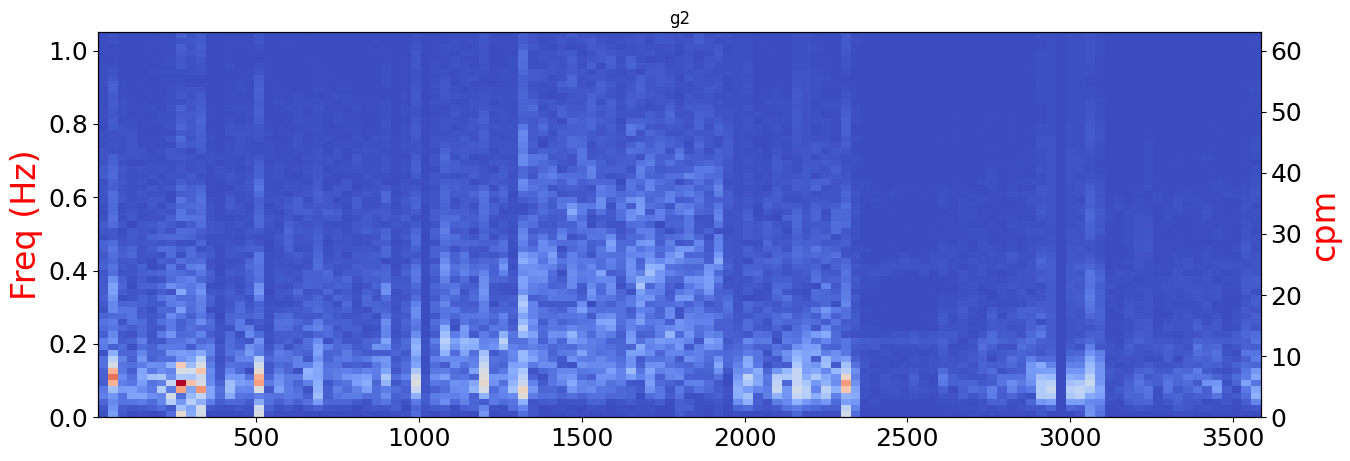

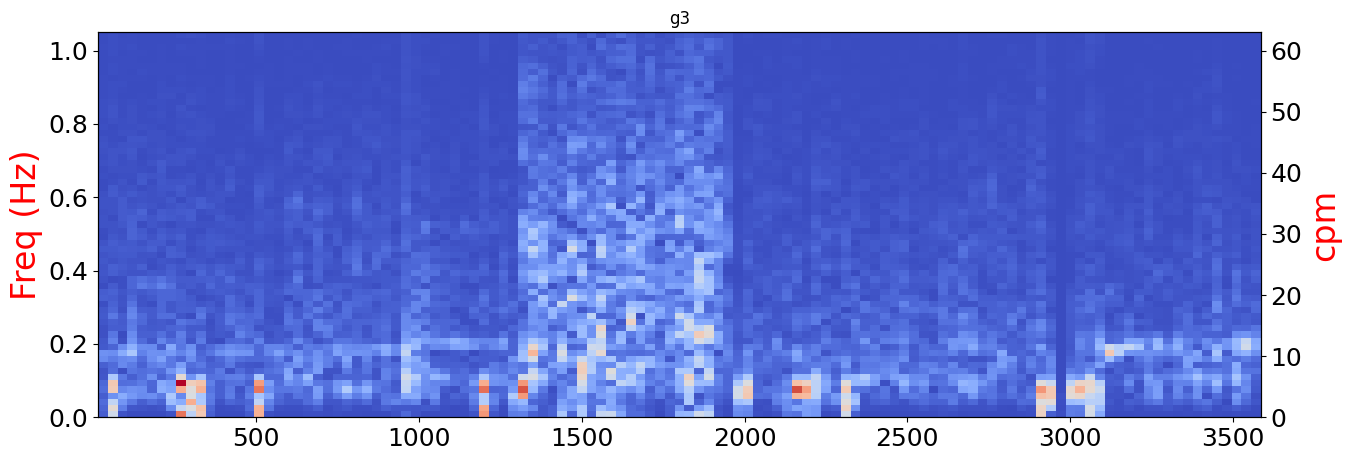

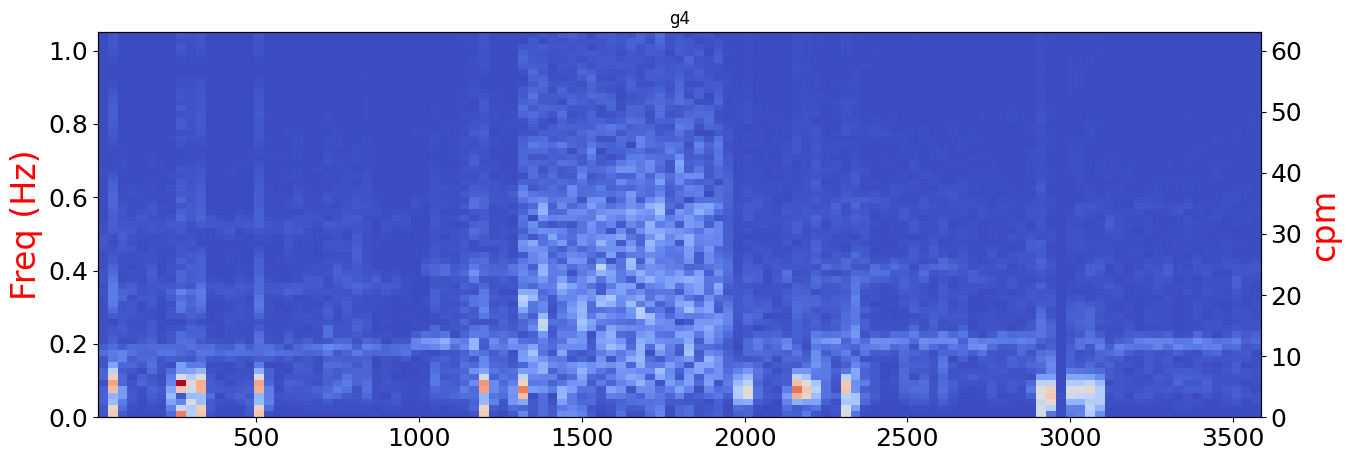

#########################################################

In [17]:
for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        Plotting.spect(arr=df_x[y], sample_freq=new_sample_freq, y_max_freq=1.5*hi_cutoff, plot_title=y)
        
    print('#########################################################')
    print()

# make summary table

In [18]:
# use deep = true to make sure that original will not be changed when modifying copy
df_copy = df_summary.copy(deep=True)

# add columns
df_copy['packet_remove_pct'] = df_packet_drop['removed_pct'].values
df_copy['art_remove_pct'] = df_artifact_remove['removed_pct'].values
df_copy['animal'] = pd.Series(animal, index=df_copy.index)
df_copy['new_sample_freq'] = pd.Series(new_sample_freq, index=df_copy.index)
df_copy['filter_type'] = pd.Series(filter_type, index=df_copy.index)
df_copy['lo_cutoff'] = pd.Series(lo_cutoff, index=df_copy.index)
df_copy['hi_cutoff'] = pd.Series(hi_cutoff, index=df_copy.index)
df_copy['remove_drop_packs'] = pd.Series(use_dropped_packet_removal, index=df_copy.index)
df_copy['remove_artifact'] = pd.Series(use_artifact_removal, index=df_copy.index)

# reorder columns
df_copy = df_copy[['animal', 'cond', 'chan', 'new_sample_freq', 'filter_type', 'lo_cutoff', 'hi_cutoff', 
                   'remove_drop_packs', 'remove_artifact', 'tot_power', 'brad_power', 
                   'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf', 'packet_remove_pct', 'art_remove_pct']]

# replace characters
df_copy['cond'] = df_copy.cond.str.replace('df_', '')

print(df_copy)

# Write to file
results_file = 'summary.csv'

# make a results file
if not os.path.exists(results_file):
    os.mknod(results_file)
    df_copy.to_csv(results_file)  
elif os.path.exists(results_file):
    df_copy.to_csv(results_file, mode='a', header=False)

animal  cond chan  new_sample_freq filter_type  lo_cutoff  hi_cutoff  \
0  58-21  base   g1              200    bandpass       0.05        0.7   
0  58-21  base   g2              200    bandpass       0.05        0.7   
0  58-21  base   g3              200    bandpass       0.05        0.7   
0  58-21  base   g4              200    bandpass       0.05        0.7   
0  58-21  feed   g1              200    bandpass       0.05        0.7   
0  58-21  feed   g2              200    bandpass       0.05        0.7   
0  58-21  feed   g3              200    bandpass       0.05        0.7   
0  58-21  feed   g4              200    bandpass       0.05        0.7   

   remove_drop_packs  remove_artifact     tot_power    brad_power  \
0               True             True  7.620452e+07  4.082170e+07   
0               True             True  8.293644e+08  6.230551e+08   
0               True             True  1.430215e+08  7.697005e+07   
0               True             True  1.172734e+08  8.343785e+07   
0               True             True  1.996004e+08  1.312840e+08   
0               True             True  3.115606e+08  1.786668e+08   
0               True             True  4.054221e+08  2.175782e+08   
0               True             True  2.322553e+08  1.439988e+08   

     norm_power    tach_power  brad_domf  norm_domf  tach_domf  \
0  3.138870e+07  3.994126e+06     0.0700     0.1739     0.1906   
0  1.511911e+08  5.511819e+07     0.0661     0.1672     0.2100   
0  5.413465e+07  1.191681e+07     0.0689     0.1661     0.1944   
0  2.834759e+07  5.487977e+06     0.0728     0.1733     0.1978   
0  4.199898e+07  2.631745e+07     0.0581     0.1764     0.1924   
0  7.392675e+07  5.896705e+07     0.0769     0.1283     0.1913   
0  9.734106e+07  9.050285e+07     0.0581     0.1465     0.2068   
0  4.390251e+07  4.435403e+07     0.0769     0.1355     0.1963   

   packet_remove_pct  art_remove_pct  
0               0.45            1.97  
0               0.45            6.14  
0               0.45            1.92  
0               0.45            1.24  
0              18.27            6.46  
0              18.35            2.84  
0              17.85            7.32  
0              18.16            5.37

# make filtered files

In [19]:
if not os.path.exists('final_filt_data'):
    os.mkdir('final_filt_data')
    
for x in df_name_lst:

    df_x = locals()[x]    
    
    # make csv
    df_x.to_csv('final_filt_data/' + animal + '_' + x + '.csv', index=False)
    
    # make pickle
    f = open('final_filt_data/' + animal + '_' + x + '.pckl', 'wb')
    pickle.dump(df_x, f)
    f.close()